# Homework 3
## Jack McCall
## ESE 417

In [1]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score

__1a1)__ _Use Python to generate a 2D (𝒙𝑖 ∈ℛ2) linearly separable data set with 50 data 
points. The data set should have approximately half positive and half negative 
instances. Create a scatter plot to visualize the data set. Split the data set into 
training set (60%) and test set (40%)._

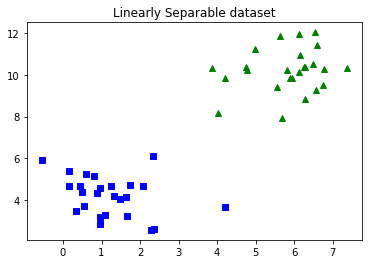

In [2]:
#creating dataset

#n_samples = num of datapoints
#centers = number of centers for the datapoints
#n_features = number of features
#center_box = the bounding box for each cluster
#cluster_std = standard deviation of the clusters
#random_state = determines random number generation for reproducible output among multiple function calls

num_features1 = 2
num_datapoints1 = 50
X1, y1 = datasets.make_blobs(n_samples=num_datapoints1, centers=2, n_features=num_features1, center_box=(0, 10), cluster_std=1, random_state=1247)

#Creating scatter plot to visualize
plt.plot(X1[:, 0][y1 == 0], X1[:, 1][y1 == 0], 'g^')
plt.plot(X1[:, 0][y1 == 1], X1[:, 1][y1 == 1], 'bs')
plt.title("Linearly Separable dataset")
plt.show()

y1 = y1*2-1
y1 = y1.reshape(num_datapoints1, 1)

#splitting into 60-40 training/testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.4,random_state=420)

__1a2)__ _Use Python (not sklearn package) to create the Batch Perceptron training algorithm 
and use the training data set in a.(1) to train a Perceptron model. Plot the error 
function curve when the training process converges. Create a plot that shows the 
training instances and the learnt decision boundary._

In [3]:
class Perceptron(object):
    
    #Initialize everything
    def __init__(self, X_train, y_train, learning_rate, max_epochs = 100):
        # add one for bias to X_train, save as local to this perceptron class
        self.number_of_datapoints, _ = X_train.shape
        self.X_train = np.c_[np.ones(self.number_of_datapoints), X_train]
        
        #create w_star
        _, self.w_star_dimensions = self.X_train.shape         #grab the number of features in X_train datapoints
        self.w_star = (np.zeros([self.w_star_dimensions, 1]))   #initialize w_star to be 0's
        
        #initialize other variables from parameters
        self.learning_rate = learning_rate          #learning rate
        self.max_epochs = max_epochs                #max number of epochs
        self.y_true = y_train                       #y values for training
        self.num_of_points = len(self.y_true)       #number of datapoints being used

    #this function manually sets the w_star values
    #this is used for testing convergence rates, since I am not sure whether the initial weight vector
    #is supposed to be 0 or random
    def set_w_star(self, w0, w1, w2):
        self.w_star[0] = w0
        self.w_star[1] = w1
        self.w_star[2] = w2
        
    #calculates the predicted class for each datapoint in X_train using the decision rule with current weight vector
    #np.dot(wT,xi) > 0, then xi is in class 1(y = 1)
    #np.dot(wT,xi) < 0, then xi is in class 2(y = 0)
    def predict_class(self, x):
        predicted_class = x.dot(self.w_star)
        return 2*(predicted_class>0)-1  #returns sign of predicted_class

    #fits the model using batch training on the current dataset
    def batch_fit(self, verbose = False, plot = False):
        #runs a max of max_epochs
        errors = []  #holds the error for each epoch
        for current_epoch in range(self.max_epochs):
            misclassified_points = []
            
            #go through entire X_train at once, then update w_star
            for i in range(self.num_of_points):
                predicted_class = self.predict_class(self.X_train[i])   #predict class
                if predicted_class != self.y_true[i]:   #compare to true class
                    misclassified_points.append(self.X_train[i] * self.y_true[i])
                    
            #if there were no misclassified points, break out(we have found w_star)
            #else, update w_star and go again
            if len(misclassified_points) == 0:
                break
            else:
                sum_misclassified_points = sum(misclassified_points)
                sum_times_learning_rate = sum_misclassified_points * self.learning_rate
                errors.append(self.calculate_error())
                #add sum_times_learing_rate to w_star
                for i in range(len(self.w_star)):
                    self.w_star[i] += sum_times_learning_rate[i]
    
            #if verbose, print details for each epoch
            if verbose:
                print("Epoch: ", current_epoch)
                print("w_star: ", self.w_star)
                print("Error: ", self.calculate_error())
            #if we need to plot, call plot
            if plot:
                self.plot(self.w_star[1], self.w_star[2], self.w_star[0], current_epoch)
                
        #return weight vector, error list, and epochs iterated through
        return self.w_star, errors, current_epoch+1
    
    #fits the model using sequential training on the current dataset
    def sequential_fit(self, verbose = False, plot = False):
        #runs a max of max_epochs
        errors = []  #holds the error for each epoch
        weight_vectors = []       #holds the weight vector for each epoch
        for current_epoch in range(self.max_epochs):
            weight_vectors.append(self.w_star)  #add weight vector to weight vector list
            #check to see if every prediction is correct
            #np.all checks to see if every element is true
            #np.squeeze pushes into 1d array
            if np.all(np.squeeze(self.predict_class(self.X_train)) == np.squeeze(self.y_true)):
                break

            #go through entire X_train updating w_star along the way
            for i in range(self.num_of_points):
                predicted_class = self.predict_class(self.X_train[i])   #predict class
                if predicted_class != self.y_true[i]:   #compare to true class
                    #add sum_times_learing_rate to w_star
                    update = self.learning_rate*(self.y_true[i] * self.X_train[i].reshape([self.w_star_dimensions,1]))
                    self.w_star = self.w_star + update
            errors.append(self.calculate_error())  #add error to error list       

            #if verbose, print details for each epoch
            if verbose:
                print("Epoch: ", current_epoch)
                print("w_star: ", self.w_star)
                print("Error: ", self.calculate_error())
            #if we need to plot, call plot
            if plot:
                self.plot(self.w_star[1], self.w_star[2], self.w_star[0], current_epoch)
                
        #return weight vector, error list, and epochs iterated through
        return weight_vectors, errors, current_epoch+1
    
    #fits the model using batch training on the current dataset
    def non_separable_batch_fit(self, verbose = False, plot = False):
        #runs a max of max_epochs
        errors = []  #holds the error for each epoch
        weight_vector_importances = []  #holds the number of correct predictions for each weight vector
        weight_vectors = []       #holds the weight vector for each epoch
        weight_vector_importance = 0   #holds the importance of the weight vector for each epoch
        for current_epoch in range(self.max_epochs):
            misclassified_points = []
            
            #go through entire X_train at once, then update w_star
            for i in range(self.num_of_points):
                predicted_class = self.predict_class(self.X_train[i])   #predict class
                if predicted_class == self.y_true[i]:  #if correct, add 1 to number_of_correct_predictions
                    weight_vector_importance = weight_vector_importance + 1
                else:   #compare to true class
                    misclassified_points.append(self.X_train[i] * self.y_true[i])
             
            #after calculating the number of correct predictions, update our output lists
            weight_vector_importances.append(weight_vector_importance)
            weight_vectors.append(self.w_star)
            weight_vector_importance = 1
            
            #if there were no misclassified points, break out(we have found w_star)
            #else, update w_star and go again
            if len(misclassified_points) == 0:
                break
            else:
                sum_misclassified_points = sum(misclassified_points)
                sum_times_learning_rate = sum_misclassified_points * self.learning_rate
                errors.append(self.calculate_error())
                #add sum_times_learing_rate to w_star
                for i in range(len(self.w_star)):
                    self.w_star[i] += sum_times_learning_rate[i]
    
            #if verbose, print details for each epoch
            if verbose:
                print("Epoch: ", current_epoch)
                print("w_star: ", self.w_star)
                print("Importance of w_star: ", weight_vector_importance)
                print("Error: ", self.calculate_error())
            #if we need to plot, call plot
            if plot:
                self.plot(self.w_star[1], self.w_star[2], self.w_star[0], current_epoch)
                
        #return weight vector, error list, and epochs iterated through
        return weight_vectors, weight_vector_importances, errors, current_epoch+1
    
    #This assumes that the dataset is NOT linearly separable
    def predict_nonseparable_class(self, x, importances, weights):
        prediction_sum = 0
        for i in range(len(importances)):
            #make prediction based on average of all importances for each weight vector 
            prediction_sum += (importances[i] * (x.dot(weights[i])))
        prediction_average = prediction_sum / len(importances)   #average prediction sum
        return 2*(prediction_average>0)-1  #returns sign of predictions_sum
    
    def calculate_nonseparable_error(self, X_test, y_test, importances, weights):
        diff = y_test-self.predict_nonseparable_class(X_test, importances, weights)
        return (diff.T@diff)[0,0]
    
    #plots the line of an epoch compared to the dataset
    def plot(self, a, b, bias, epoch):
        y = self.y_true.reshape(len(self.y_true),)  #reshape y_true so we can graph
        plt.plot(self.X_train[:, 1][y == -1], self.X_train[:, 2][y == -1], 'g^')
        plt.plot(self.X_train[:, 1][y ==  1], self.X_train[:, 2][y ==  1], 'bs')

        xx = np.linspace(-11,11,5000)  #x values for our line
        yy = (a*xx + bias)/(-1*b)      #y values for our line, follows forumla ax+by=c
        plt.plot(xx, yy)
        plt.title("epoch "+str(epoch))
        plt.xlim(np.min(self.X_train[:, 1])-1, np.max(self.X_train[:, 1])+1)
        plt.ylim(np.min(self.X_train[:, 2])-1, np.max(self.X_train[:, 2])+1)
        plt.show()
        
    #plots the final decision boundary    
    def plot_final(self):
        a = self.w_star[1]
        b = self.w_star[2]
        bias = self.w_star[0]
        y = self.y_true.reshape(len(self.y_true),)  #reshape y_true so we can graph
        plt.plot(self.X_train[:, 1][y == -1], self.X_train[:, 2][y == -1], 'g^')
        plt.plot(self.X_train[:, 1][y ==  1], self.X_train[:, 2][y ==  1], 'bs')

        xx = np.linspace(-11,11,5000)  #x values for our line
        yy = (a*xx + bias)/(-1*b)      #y values for our line, follows forumla ax+by=c
        plt.plot(xx, yy)
        plt.title("Final Decision Boundary")
        plt.xlim(np.min(self.X_train[:, 1])-1, np.max(self.X_train[:, 1])+1)
        plt.ylim(np.min(self.X_train[:, 2])-1, np.max(self.X_train[:, 2])+1)
        plt.show()
        
    #calculates the error of a dataset
    def calculate_error(self, X_test=None, y_test=None):
        """
        Used to calculate the residual sum of squares (RSS) error.
        If X_test and y_test are not given, returns the training RSS,
        otherwise test RSS.
        """
        if X_test is None:
            diff = self.y_true-self.predict_class(self.X_train)
        else:
            diff = y_test-self.predict_class(X_test)
        return (diff.T@diff)[0,0]



Epoch:  0
w_star:  [[ 32.        ]
 [ 41.83887201]
 [128.51540014]]
Error:  56


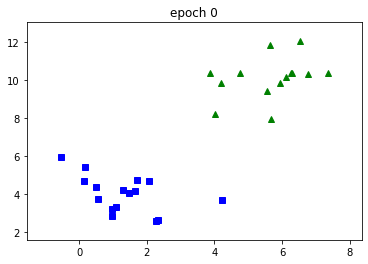

Epoch:  1
w_star:  [[   4.        ]
 [-116.12946715]
 [-154.02328102]]
Error:  64


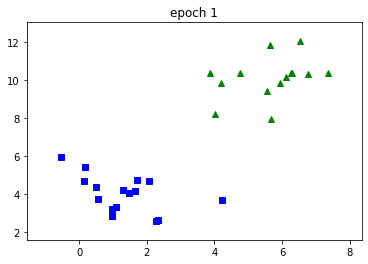

Epoch:  2
w_star:  [[ 36.        ]
 [-74.29059515]
 [-25.50788088]]
Error:  64


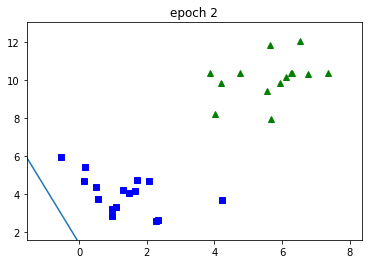

Epoch:  3
w_star:  [[ 68.        ]
 [-32.45172314]
 [103.00751926]]
Error:  56


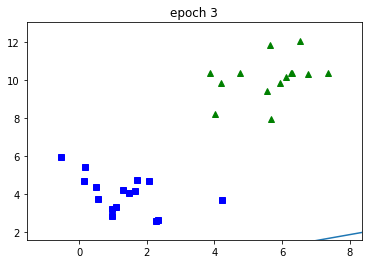

Epoch:  4
w_star:  [[  40.       ]
 [-190.4200623]
 [-179.5311619]]
Error:  64


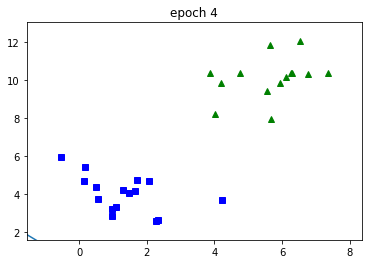

Epoch:  5
w_star:  [[  72.        ]
 [-148.58119029]
 [ -51.01576176]]
Error:  64


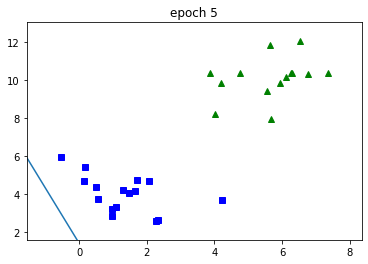

Epoch:  6
w_star:  [[ 104.        ]
 [-106.74231829]
 [  77.49963838]]
Error:  60


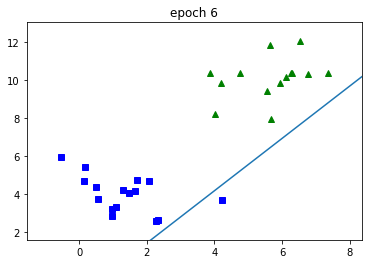

Epoch:  7
w_star:  [[  78.        ]
 [-256.28143046]
 [-197.63146073]]
Error:  64


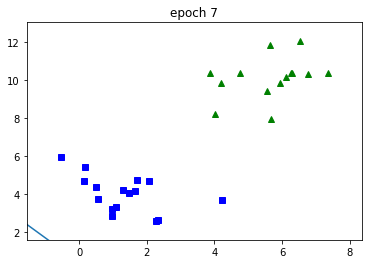

Epoch:  8
w_star:  [[ 110.        ]
 [-214.44255846]
 [ -69.11606059]]
Error:  64


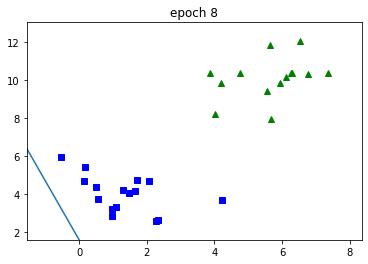

Epoch:  9
w_star:  [[ 142.        ]
 [-172.60368645]
 [  59.39933955]]
Error:  20


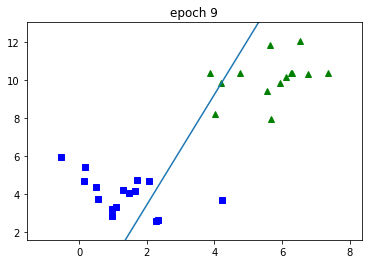

Epoch:  10
w_star:  [[ 144.        ]
 [-171.03249895]
 [  36.92365762]]
Error:  16


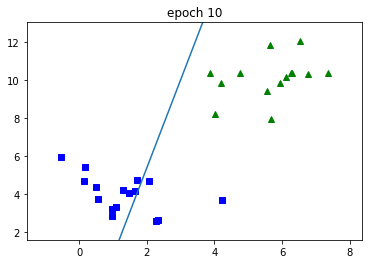

Epoch:  11
w_star:  [[ 152.        ]
 [-149.17909249]
 [  64.13163882]]
Error:  32


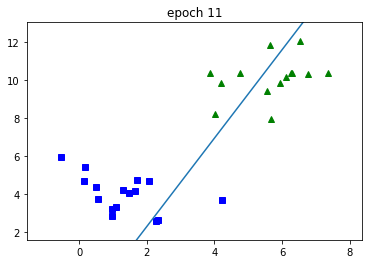

Epoch:  12
w_star:  [[ 148.        ]
 [-176.45303596]
 [ -19.10691895]]
Error:  52


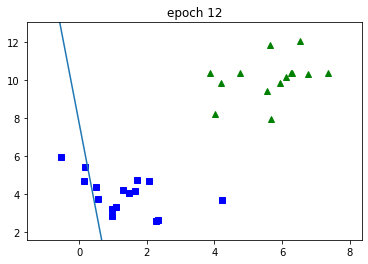

Epoch:  13
w_star:  [[ 174.        ]
 [-134.16932196]
 [  77.38214955]]
Error:  56


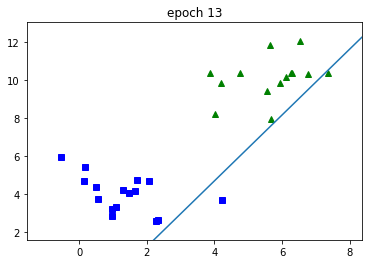

Epoch:  14
w_star:  [[ 150.        ]
 [-268.99620135]
 [-177.06065618]]
Error:  64


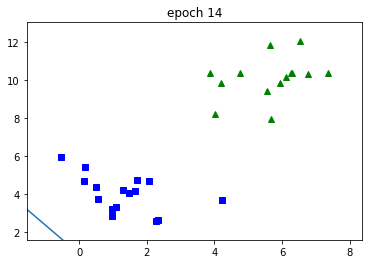

Epoch:  15
w_star:  [[ 182.        ]
 [-227.15732934]
 [ -48.54525604]]
Error:  60


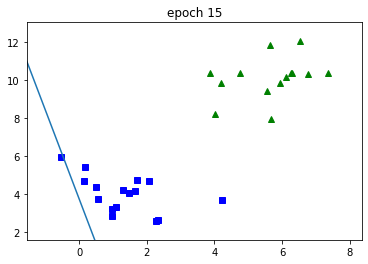

Epoch:  16
w_star:  [[ 212.        ]
 [-184.23639737]
 [  68.12587555]]
Error:  28


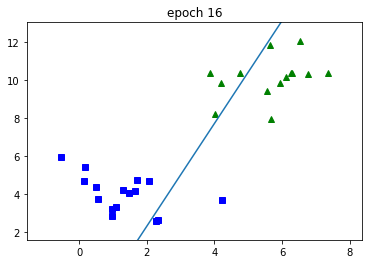

Epoch:  17
w_star:  [[ 210.        ]
 [-200.22562769]
 [   8.56168677]]
Error:  32


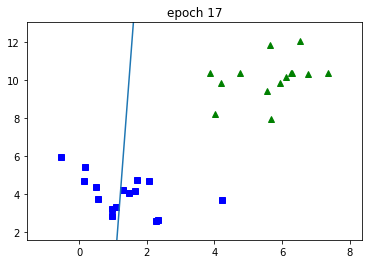

Epoch:  18
w_star:  [[ 226.        ]
 [-166.06532193]
 [  70.09760844]]
Error:  24


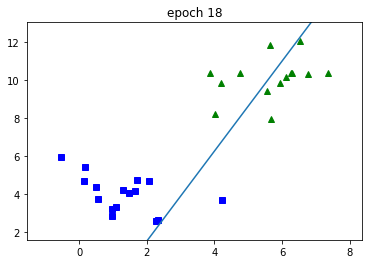

Epoch:  19
w_star:  [[ 218.        ]
 [-202.60573682]
 [ -23.60106286]]
Error:  44


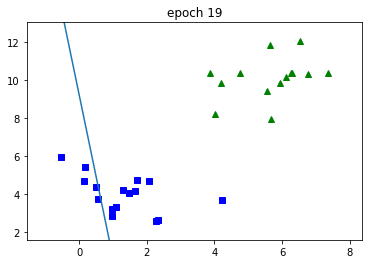

Epoch:  20
w_star:  [[ 240.        ]
 [-162.42198447]
 [  56.63862569]]
Error:  20


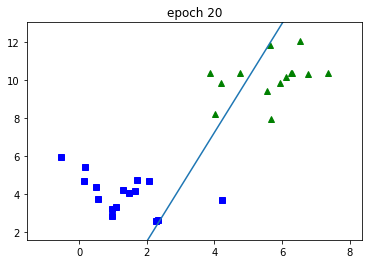

Epoch:  21
w_star:  [[ 234.        ]
 [-187.67768619]
 [ -13.38567661]]
Error:  36


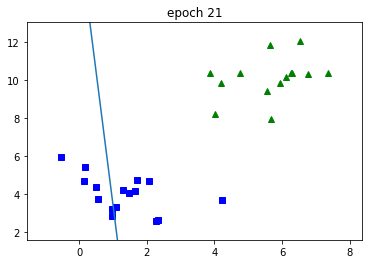

Epoch:  22
w_star:  [[ 252.        ]
 [-151.35339736]
 [  54.74667645]]
Error:  24


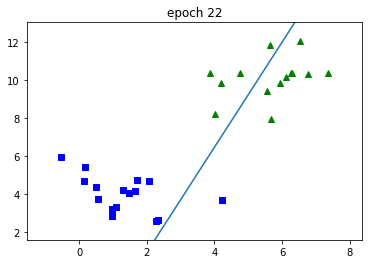

Epoch:  23
w_star:  [[ 244.        ]
 [-187.89381225]
 [ -38.95199484]]
Error:  52


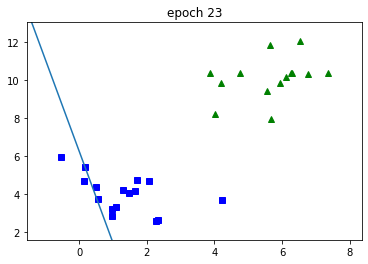

Epoch:  24
w_star:  [[ 270.        ]
 [-145.61009825]
 [  57.53707366]]
Error:  32


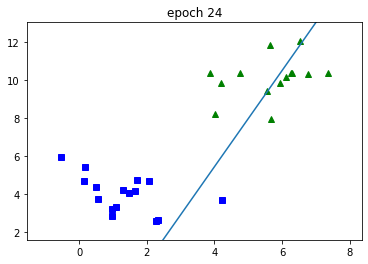

Epoch:  25
w_star:  [[ 258.        ]
 [-206.34334149]
 [ -79.02705137]]
Error:  64


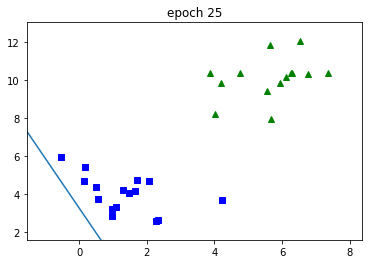

Epoch:  26
w_star:  [[ 290.        ]
 [-164.50446949]
 [  49.48834876]]
Error:  20


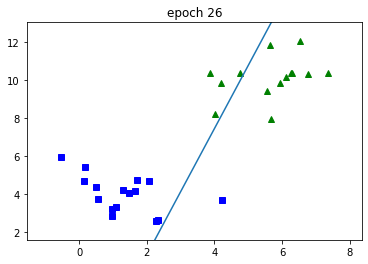

Epoch:  27
w_star:  [[ 284.        ]
 [-189.76017122]
 [ -20.53595354]]
Error:  32


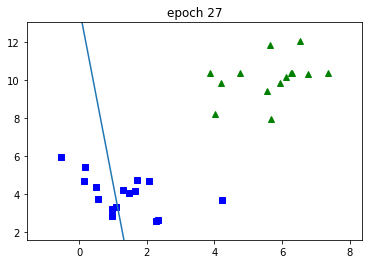

Epoch:  28
w_star:  [[ 300.        ]
 [-155.59986546]
 [  40.99996813]]
Error:  16


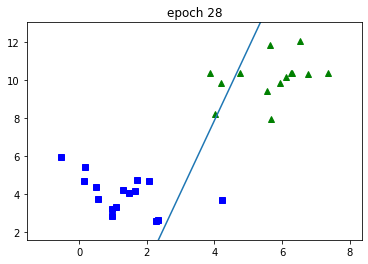

Epoch:  29
w_star:  [[ 296.        ]
 [-171.33944467]
 [  -8.29807415]]
Error:  24


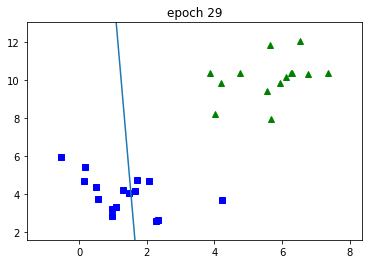

Epoch:  30
w_star:  [[ 308.        ]
 [-142.74255906]
 [  36.69103357]]
Error:  20


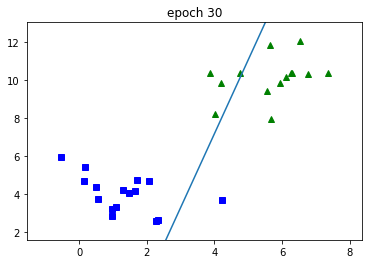

Epoch:  31
w_star:  [[ 302.        ]
 [-167.99826079]
 [ -33.33326873]]
Error:  32


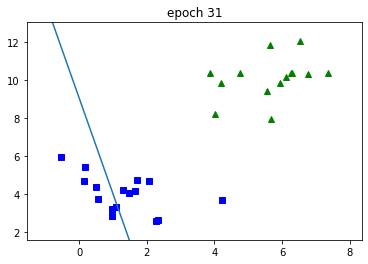

Epoch:  32
w_star:  [[ 318.        ]
 [-133.83795503]
 [  28.20265294]]
Error:  16


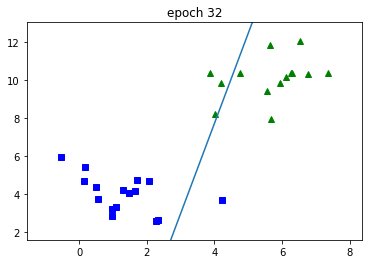

Epoch:  33
w_star:  [[ 314.        ]
 [-149.57753424]
 [ -21.09538934]]
Error:  24


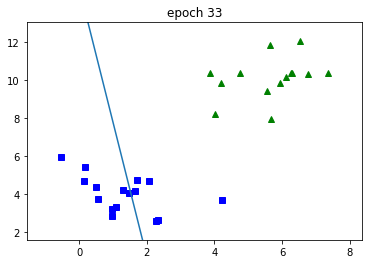

Epoch:  34
w_star:  [[ 326.        ]
 [-120.98064863]
 [  23.89371838]]
Error:  16


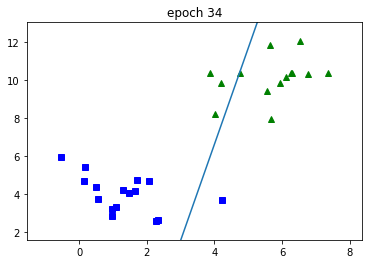

Epoch:  35
w_star:  [[ 322.        ]
 [-136.72022785]
 [ -25.4043239 ]]
Error:  24


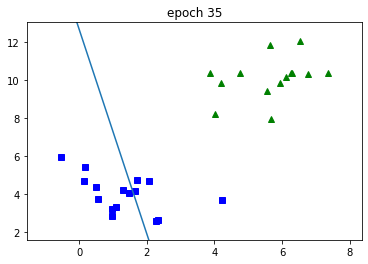

Epoch:  36
w_star:  [[ 334.        ]
 [-108.12334223]
 [  19.58478382]]
Error:  20


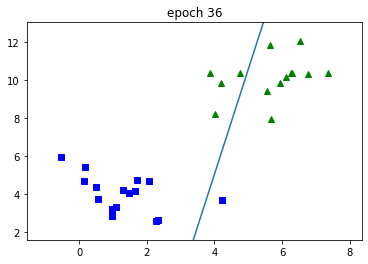

Epoch:  37
w_star:  [[ 328.        ]
 [-133.37904396]
 [ -50.43951848]]
Error:  32


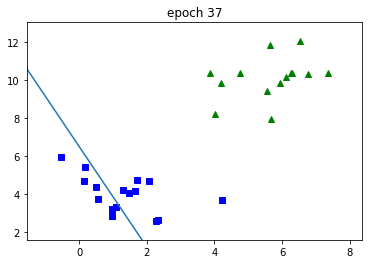

Epoch:  38
w_star:  [[344.        ]
 [-99.2187382 ]
 [ 11.09640319]]
Error:  16


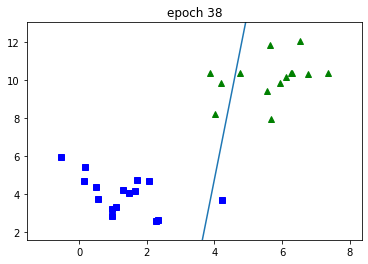

Epoch:  39
w_star:  [[ 340.        ]
 [-114.95831742]
 [ -38.20163909]]
Error:  24


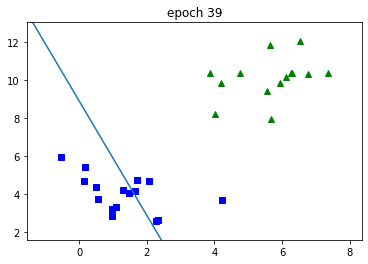

Epoch:  40
w_star:  [[352.        ]
 [-86.36143181]
 [  6.78746862]]
Error:  16


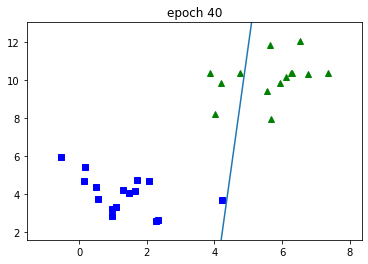

Epoch:  41
w_star:  [[ 344.        ]
 [-120.04636052]
 [ -70.64441573]]
Error:  52


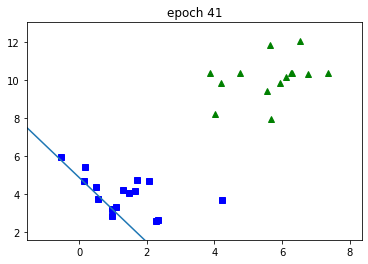

Epoch:  42
w_star:  [[370.        ]
 [-83.17100322]
 [ 38.28771567]]
Error:  56


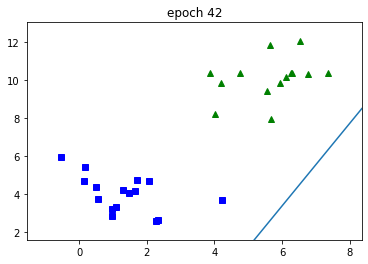

Epoch:  43
w_star:  [[ 342.        ]
 [-241.13934238]
 [-244.25096549]]
Error:  64


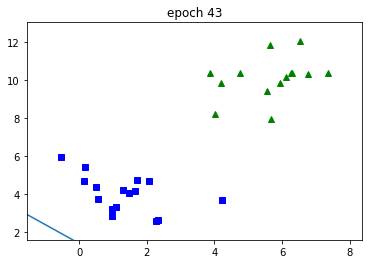

Epoch:  44
w_star:  [[ 374.        ]
 [-199.30047038]
 [-115.73556535]]
Error:  64


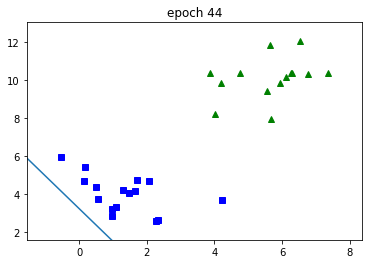

Epoch:  45
w_star:  [[ 406.        ]
 [-157.46159837]
 [  12.77983479]]
Error:  4


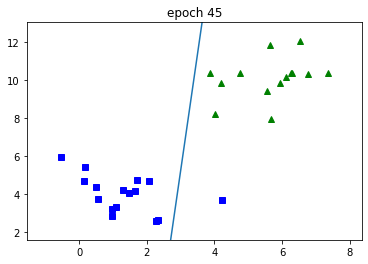

Epoch:  46
w_star:  [[ 408.        ]
 [-149.03237138]
 [  20.18741684]]
Error:  8


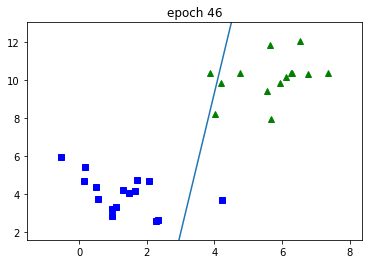

Epoch:  47
w_star:  [[ 408.        ]
 [-148.32701261]
 [   6.91435343]]
Error:  4


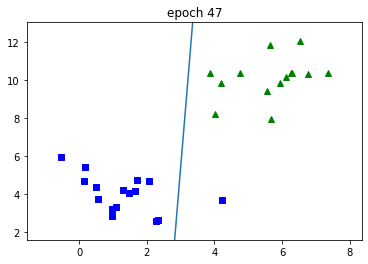

Epoch:  48
w_star:  [[ 410.        ]
 [-139.89778563]
 [  14.32193549]]
Error:  8


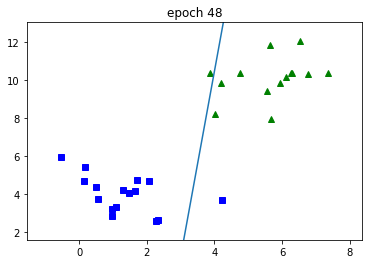

Epoch:  49
w_star:  [[ 410.        ]
 [-139.19242685]
 [   1.04887208]]
Error:  4


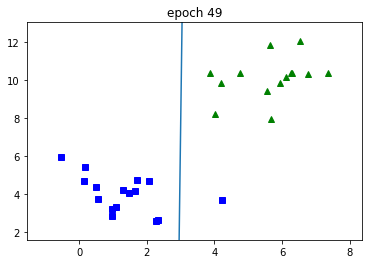

Epoch:  50
w_star:  [[ 412.        ]
 [-130.76319987]
 [   8.45645414]]
Error:  4


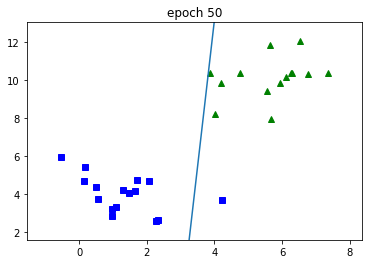

Epoch:  51
w_star:  [[ 414.        ]
 [-122.33397288]
 [  15.8640362 ]]
Error:  16


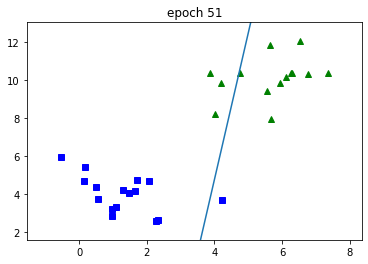

Epoch:  52
w_star:  [[ 410.        ]
 [-138.0735521 ]
 [ -33.43400608]]
Error:  12


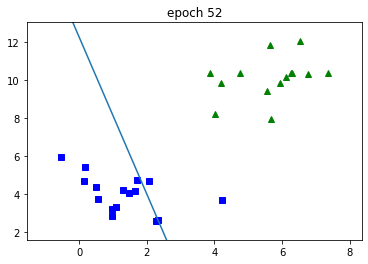

Epoch:  53
w_star:  [[ 416.        ]
 [-120.79110204]
 [ -11.40134996]]
Error:  4


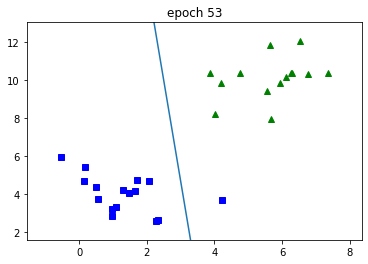

Epoch:  54
w_star:  [[ 418.        ]
 [-112.36187506]
 [  -3.9937679 ]]
Error:  4


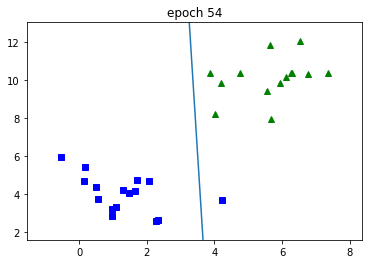

Epoch:  55
w_star:  [[ 420.        ]
 [-103.93264807]
 [   3.41381415]]
Error:  16


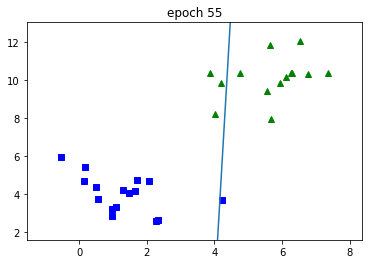

Epoch:  56
w_star:  [[ 416.        ]
 [-119.67222729]
 [ -45.88422813]]
Error:  12


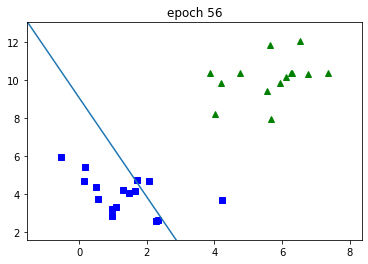

Epoch:  57
w_star:  [[ 422.        ]
 [-103.63229949]
 [ -19.64807771]]
Error:  4


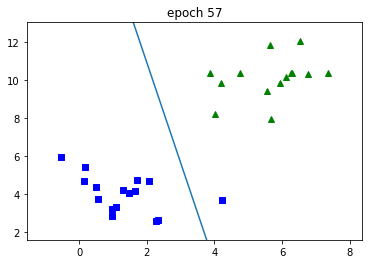

Epoch:  58
w_star:  [[424.        ]
 [-95.20307251]
 [-12.24049566]]
Error:  4


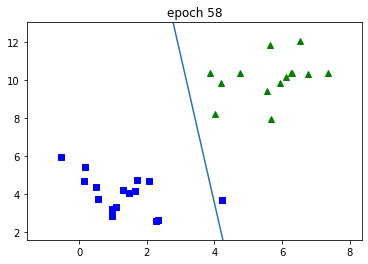

Epoch:  59
w_star:  [[426.        ]
 [-86.77384552]
 [ -4.8329136 ]]
Error:  12


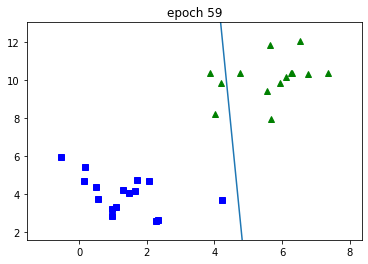

Epoch:  60
w_star:  [[ 420.        ]
 [-110.94265172]
 [ -61.53853794]]
Error:  20


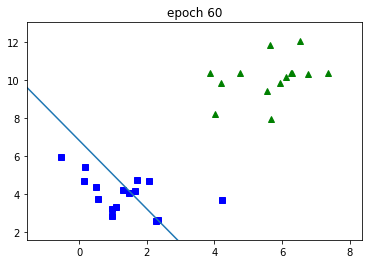

Epoch:  61
w_star:  [[430.        ]
 [-86.91672252]
 [-21.72475529]]
Error:  4


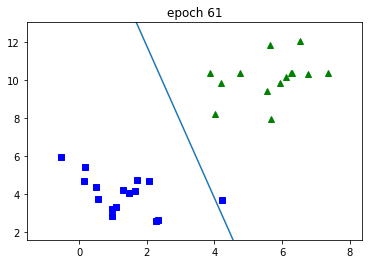

Epoch:  62
w_star:  [[432.        ]
 [-78.48749554]
 [-14.31717324]]
Error:  0


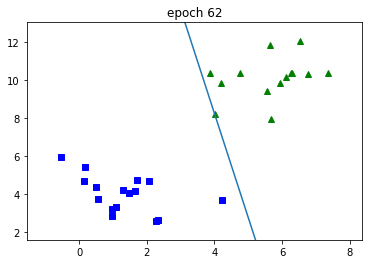

In [4]:
#training using batch fitting
batch_perceptron = Perceptron(X1_train, y1_train, learning_rate = 2, max_epochs=100)
batch_w, batch_all_errors, batch_epochs_iterated = batch_perceptron.batch_fit(verbose = True, plot = True)

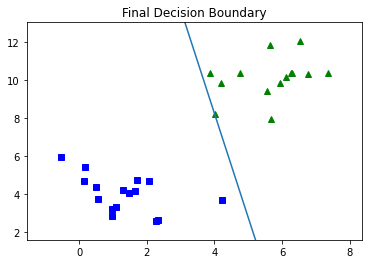

In [5]:
batch_perceptron.plot_final()

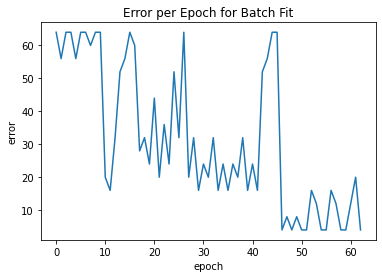

In [6]:
#plotting error
plt.plot(batch_all_errors)
plt.ylabel('error')
plt.xlabel('epoch')
plt.title('Error per Epoch for Batch Fit')
plt.show()

__1a3)__ _Use the test set in a.(1) to test the trained model in a.(2) and calculate the accuracy 
(error rate) of the trained model._

In [7]:
#calculating error for test dataset with batch fit
batch_y1_pred = []
concatenated_X1_test = np.c_[np.ones(len(y1_test)), X1_test]  #adding 1's to front of X_test for bias
for i in range(len(concatenated_X1_test)):
    batch_y1_pred.append(batch_perceptron.predict_class(concatenated_X1_test[i]))
batch_acc1 = accuracy_score(y1_test, batch_y1_pred)
print("Accuracy score for Batch Training: ", batch_acc1)

Accuracy score for Batch Training:  1.0


__1a4)__ _Use Python (not sklearn package) to create the sequential Perceptron training 
algorithm and use the training data set in a.(1) to train a Perceptron model. Plot the 
weights vs iterations curve when the training process converges. Create a plot that 
shows the training instances and the resulting decision boundary._

__I added this to my Perceptron class above__

Epoch:  0
w_star:  [[0.6       ]
 [0.07279111]
 [0.39546473]]
Error:  56


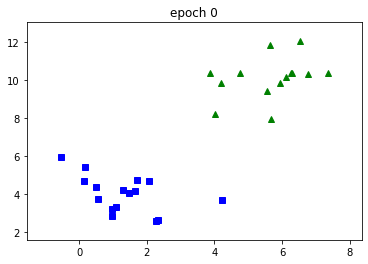

Epoch:  1
w_star:  [[ 1.1       ]
 [-0.70500544]
 [-0.31308605]]
Error:  64


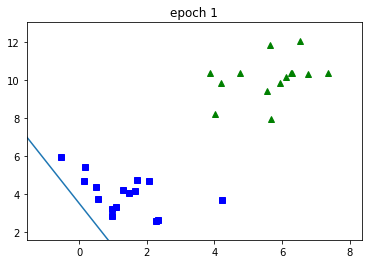

Epoch:  2
w_star:  [[ 1.6       ]
 [-0.20474766]
 [ 0.40786213]]
Error:  56


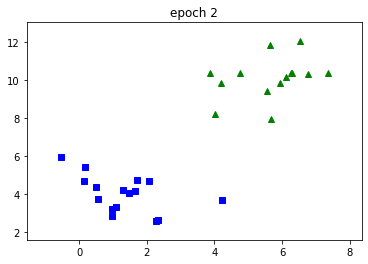

Epoch:  3
w_star:  [[ 1.8       ]
 [-0.16383621]
 [ 0.31979345]]
Error:  56


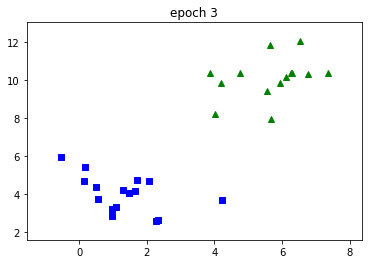

Epoch:  4
w_star:  [[ 2.        ]
 [-0.12292476]
 [ 0.23172477]]
Error:  56


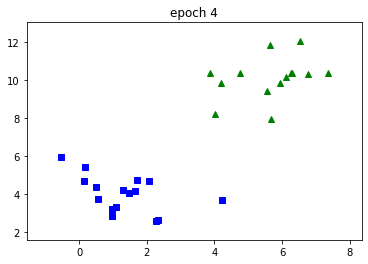

Epoch:  5
w_star:  [[2.4       ]
 [0.03701206]
 [0.17779881]]
Error:  56


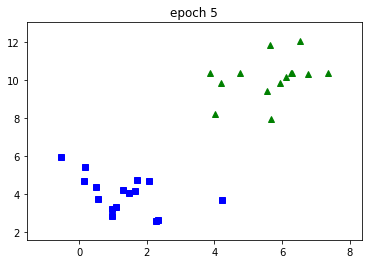

Epoch:  6
w_star:  [[ 2.5       ]
 [-0.34353783]
 [-0.28064898]]
Error:  0


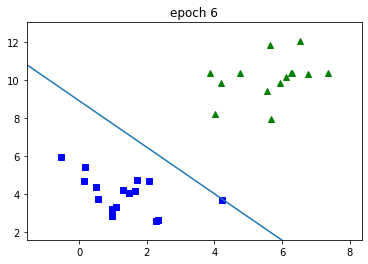

In [8]:
#Training using sequential fitting
sequential_perceptron = Perceptron(X1_train, y1_train, learning_rate = 0.1, max_epochs=100)
sequential_w_vectors, sequential_all_errors, sequential_epochs_iterated = sequential_perceptron.sequential_fit(verbose = True, plot = True)

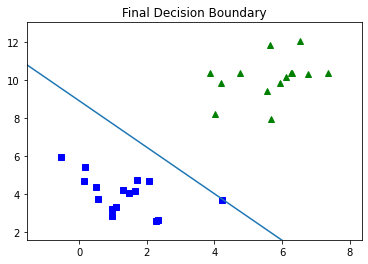

In [9]:
sequential_perceptron.plot_final()

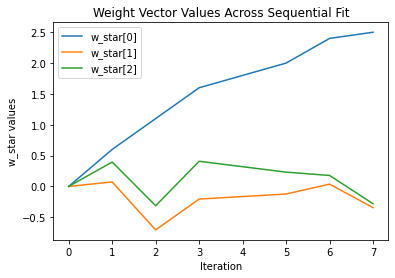

In [10]:
#plotting weight vectors

#grabbing weight values
w0 = []
w1 = []
w2 = []
for i in range(sequential_epochs_iterated):
    w_vector = sequential_w_vectors[i]
    w0.append(w_vector[0])
    w1.append(w_vector[1])
    w2.append(w_vector[2])
    
plt.plot(range(sequential_epochs_iterated), w0, label="w_star[0]")
plt.plot(range(sequential_epochs_iterated), w1, label="w_star[1]")
plt.plot(range(sequential_epochs_iterated), w2, label="w_star[2]")
plt.ylabel('w_star values')
plt.xlabel('Iteration')
plt.title('Weight Vector Values Across Sequential Fit')
plt.legend()
plt.show()

__1a5)__ _Use the test set in a.(1) to test the trained model in a. (4) and calculate the accuracy 
(error rate) of the trained model._

In [11]:
#calculating error for test dataset with batch fit
sequential_y1_pred = []
concatenated_X1_test = np.c_[np.ones(len(y1_test)), X1_test]  #adding 1's to front of X_test for bias
for i in range(len(concatenated_X1_test)):
    sequential_y1_pred.append(sequential_perceptron.predict_class(concatenated_X1_test[i]))
sequential_acc1 = accuracy_score(y1_test, sequential_y1_pred)
print("Accuracy score for Sequential Training: ", sequential_acc1)

Accuracy score for Sequential Training:  0.95


__1a6)__ _Show how you select learning rate during the training process of a.(2) or a.(4) and 
demonstrate how the choice of the learning rate is affecting the convergence of the 
training process._

Epochs til convergence with learning rate of 0.1 =  64
Epochs til convergence with learning rate of 0.01 =  64
Epochs til convergence with learning rate of 0.001 =  64
Epochs til convergence with learning rate of 0.0001 =  64


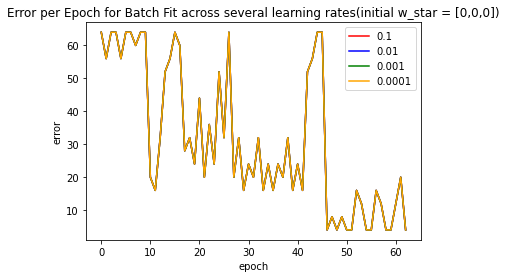

Epochs til convergence with learning rate of 0.1 =  8
Epochs til convergence with learning rate of 0.01 =  8
Epochs til convergence with learning rate of 0.001 =  8
Epochs til convergence with learning rate of 0.0001 =  8


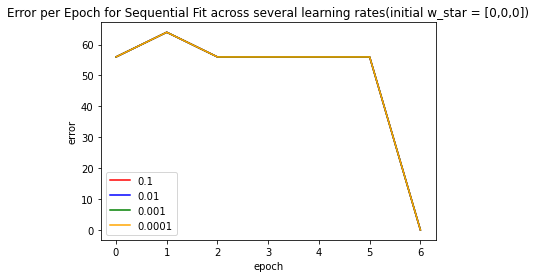

In [12]:
#
#INITIAL WEIGHT VECTOR IS [0,0,0]
#

#Training using batch fitting
batch_lr_1 = Perceptron(X1_train, y1_train, learning_rate = .1, max_epochs=100)
batch_lr_1_w, batch_lr_1_all_errors, batch_lr_1_epochs_iterated = batch_lr_1.batch_fit()
print("Epochs til convergence with learning rate of 0.1 = ", batch_lr_1_epochs_iterated)

batch_lr_01 = Perceptron(X1_train, y1_train, learning_rate = .01, max_epochs=100)
batch_lr_01_w, batch_lr_01_all_errors, batch_lr_01_epochs_iterated = batch_lr_01.batch_fit()
print("Epochs til convergence with learning rate of 0.01 = ", batch_lr_01_epochs_iterated)

batch_lr_001 = Perceptron(X1_train, y1_train, learning_rate = .001, max_epochs=100)
batch_lr_001_w, batch_lr_001_all_errors, batch_lr_001_epochs_iterated = batch_lr_001.batch_fit()
print("Epochs til convergence with learning rate of 0.001 = ", batch_lr_001_epochs_iterated)

batch_lr_0001 = Perceptron(X1_train, y1_train, learning_rate = .0001, max_epochs=100)
batch_lr_0001_w, batch_lr_0001_all_errors, batch_lr_0001_epochs_iterated = batch_lr_0001.batch_fit()
print("Epochs til convergence with learning rate of 0.0001 = ", batch_lr_0001_epochs_iterated)

#plotting errors for each learning rate
plt.plot(batch_lr_1_all_errors, c = "red", label = "0.1")
plt.plot(batch_lr_01_all_errors, c = "blue", label = "0.01")
plt.plot(batch_lr_001_all_errors, c = "green", label = "0.001")
plt.plot(batch_lr_0001_all_errors, c = "orange", label = "0.0001")
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend()
plt.title('Error per Epoch for Batch Fit across several learning rates(initial w_star = [0,0,0])')
plt.show()

#Training using sequential fitting
sequential_lr_1 = Perceptron(X1_train, y1_train, learning_rate = .1, max_epochs=100)
sequential_lr_1_w, sequential_lr_1_all_errors, sequential_lr_1_epochs_iterated = sequential_lr_1.sequential_fit()
print("Epochs til convergence with learning rate of 0.1 = ", sequential_lr_1_epochs_iterated)

sequential_lr_01 = Perceptron(X1_train, y1_train, learning_rate = .01, max_epochs=100)
sequential_lr_01_w, sequential_lr_01_all_errors, sequential_lr_01_epochs_iterated = sequential_lr_01.sequential_fit()
print("Epochs til convergence with learning rate of 0.01 = ", sequential_lr_01_epochs_iterated)

sequential_lr_001 = Perceptron(X1_train, y1_train, learning_rate = .001, max_epochs=100)
sequential_lr_001_w, sequential_lr_001_all_errors, sequential_lr_001_epochs_iterated = sequential_lr_001.sequential_fit()
print("Epochs til convergence with learning rate of 0.001 = ", sequential_lr_001_epochs_iterated)

sequential_lr_0001 = Perceptron(X1_train, y1_train, learning_rate = .0001, max_epochs=100)
sequential_lr_0001_w, sequential_lr_0001_all_errors, sequential_lr_0001_epochs_iterated = sequential_lr_0001.sequential_fit()
print("Epochs til convergence with learning rate of 0.0001 = ", sequential_lr_0001_epochs_iterated)

#plotting errors for each learning rate
plt.plot(sequential_lr_1_all_errors, c = "red", label = "0.1")
plt.plot(sequential_lr_01_all_errors, c = "blue", label = "0.01")
plt.plot(sequential_lr_001_all_errors, c = "green", label = "0.001")
plt.plot(sequential_lr_0001_all_errors, c = "orange", label = "0.0001")
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend()
plt.title('Error per Epoch for Sequential Fit across several learning rates(initial w_star = [0,0,0])')
plt.show()

Epochs til convergence with learning rate of 0.1 =  67
Epochs til convergence with learning rate of 0.01 =  63
Epochs til convergence with learning rate of 0.001 =  45
Epochs til convergence with learning rate of 0.0001 =  48


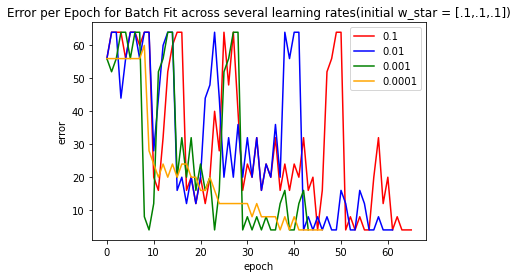

Epochs til convergence with learning rate of 0.1 =  9
Epochs til convergence with learning rate of 0.01 =  10
Epochs til convergence with learning rate of 0.001 =  6
Epochs til convergence with learning rate of 0.0001 =  44


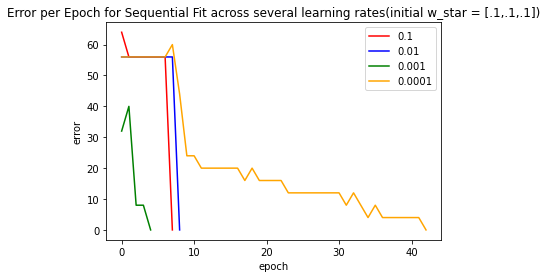

In [13]:
#
#INITIAL WEIGHT VECTOR IS [.1, .1, .1]
#

#Training using batch fitting
batch_lr2_1 = Perceptron(X1_train, y1_train, learning_rate = .1, max_epochs=100)
batch_lr2_1.set_w_star(.1,.1,.1)
batch_lr2_1_w, batch_lr2_1_all_errors, batch_lr2_1_epochs_iterated = batch_lr2_1.batch_fit()
print("Epochs til convergence with learning rate of 0.1 = ", batch_lr2_1_epochs_iterated)

batch_lr2_01 = Perceptron(X1_train, y1_train, learning_rate = .01, max_epochs=100)
batch_lr2_01.set_w_star(.1,.1,.1)
batch_lr2_01_w, batch_lr2_01_all_errors, batch_lr2_01_epochs_iterated = batch_lr2_01.batch_fit()
print("Epochs til convergence with learning rate of 0.01 = ", batch_lr2_01_epochs_iterated)

batch_lr2_001 = Perceptron(X1_train, y1_train, learning_rate = .001, max_epochs=100)
batch_lr2_001.set_w_star(.1,.1,.1)
batch_lr2_001_w, batch_lr2_001_all_errors, batch_lr2_001_epochs_iterated = batch_lr2_001.batch_fit()
print("Epochs til convergence with learning rate of 0.001 = ", batch_lr2_001_epochs_iterated)

batch_lr2_0001 = Perceptron(X1_train, y1_train, learning_rate = .0001, max_epochs=100)
batch_lr2_0001.set_w_star(.1,.1,.1)
batch_lr2_0001_w, batch_lr2_0001_all_errors, batch_lr2_0001_epochs_iterated = batch_lr2_0001.batch_fit()
print("Epochs til convergence with learning rate of 0.0001 = ", batch_lr2_0001_epochs_iterated)

#plotting errors for each learning rate
plt.plot(batch_lr2_1_all_errors, c = "red", label = "0.1")
plt.plot(batch_lr2_01_all_errors, c = "blue", label = "0.01")
plt.plot(batch_lr2_001_all_errors, c = "green", label = "0.001")
plt.plot(batch_lr2_0001_all_errors, c = "orange", label = "0.0001")
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend()
plt.title('Error per Epoch for Batch Fit across several learning rates(initial w_star = [.1,.1,.1])')
plt.show()

#Training using sequential fitting
sequential_lr2_1 = Perceptron(X1_train, y1_train, learning_rate = .1, max_epochs=100)
sequential_lr2_1.set_w_star(.1,.1,.1)
sequential_lr2_1_w, sequential_lr2_1_all_errors, sequential_lr2_1_epochs_iterated = sequential_lr2_1.sequential_fit()
print("Epochs til convergence with learning rate of 0.1 = ", sequential_lr2_1_epochs_iterated)

sequential_lr2_01 = Perceptron(X1_train, y1_train, learning_rate = .01, max_epochs=100)
sequential_lr2_01.set_w_star(.1,.1,.1)
sequential_lr2_01_w, sequential_lr2_01_all_errors, sequential_lr2_01_epochs_iterated = sequential_lr2_01.sequential_fit()
print("Epochs til convergence with learning rate of 0.01 = ", sequential_lr2_01_epochs_iterated)

sequential_lr2_001 = Perceptron(X1_train, y1_train, learning_rate = .001, max_epochs=100)
sequential_lr2_001.set_w_star(.1,.1,.1)
sequential_lr2_001_w, sequential_lr2_001_all_errors, sequential_lr2_001_epochs_iterated = sequential_lr2_001.sequential_fit()
print("Epochs til convergence with learning rate of 0.001 = ", sequential_lr2_001_epochs_iterated)

sequential_lr2_0001 = Perceptron(X1_train, y1_train, learning_rate = .0001, max_epochs=100)
sequential_lr2_0001.set_w_star(.1,.1,.1)
sequential_lr2_0001_w, sequential_lr2_0001_all_errors, sequential_lr2_0001_epochs_iterated = sequential_lr2_0001.sequential_fit()
print("Epochs til convergence with learning rate of 0.0001 = ", sequential_lr2_0001_epochs_iterated)

#plotting errors for each learning rate
plt.plot(sequential_lr2_1_all_errors, c = "red", label = "0.1")
plt.plot(sequential_lr2_01_all_errors, c = "blue", label = "0.01")
plt.plot(sequential_lr2_001_all_errors, c = "green", label = "0.001")
plt.plot(sequential_lr2_0001_all_errors, c = "orange", label = "0.0001")
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend()
plt.title('Error per Epoch for Sequential Fit across several learning rates(initial w_star = [.1,.1,.1])')
plt.show()

Random initial weight vector: [ 6.912923119238114 ,  3.3807209113634022 ,  1.0727187240482363 ]
Epochs til convergence with learning rate of 0.1 =  43
Epochs til convergence with learning rate of 0.01 =  29
Epochs til convergence with learning rate of 0.001 =  100
Epochs til convergence with learning rate of 0.0001 =  100


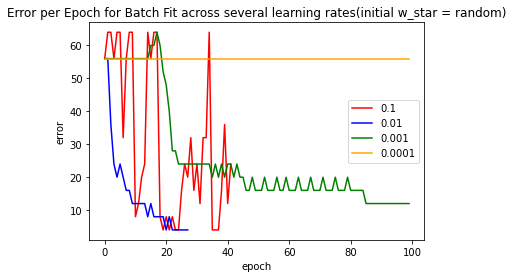

Random initial weight vector: [ 6.912923119238114 ,  3.3807209113634022 ,  1.0727187240482363 ]
Epochs til convergence with learning rate of 0.1 =  4
Epochs til convergence with learning rate of 0.01 =  26
Epochs til convergence with learning rate of 0.001 =  100
Epochs til convergence with learning rate of 0.0001 =  100


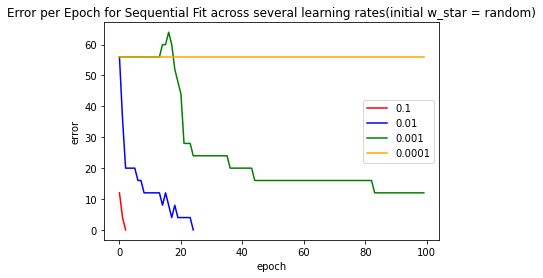

Random initial weight vector: [ 0.4233202706048792 ,  6.110161962307215 ,  8.35343350879291 ]
Epochs til convergence with learning rate of 0.1 =  64
Epochs til convergence with learning rate of 0.01 =  68
Epochs til convergence with learning rate of 0.001 =  100
Epochs til convergence with learning rate of 0.0001 =  100


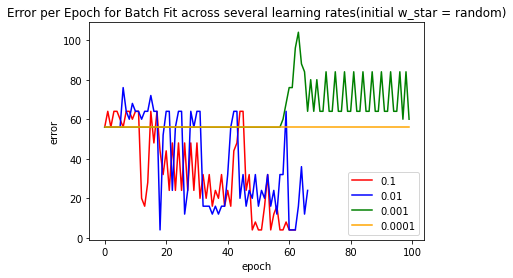

Random initial weight vector: [ 0.4233202706048792 ,  6.110161962307215 ,  8.35343350879291 ]
Epochs til convergence with learning rate of 0.1 =  6
Epochs til convergence with learning rate of 0.01 =  17
Epochs til convergence with learning rate of 0.001 =  100
Epochs til convergence with learning rate of 0.0001 =  100


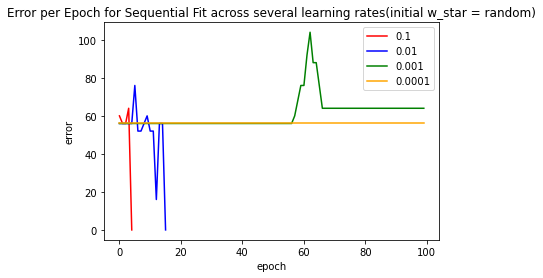

Random initial weight vector: [ 0.9841840637499941 ,  7.560342780463963 ,  6.8271661809788045 ]
Epochs til convergence with learning rate of 0.1 =  67
Epochs til convergence with learning rate of 0.01 =  27
Epochs til convergence with learning rate of 0.001 =  100
Epochs til convergence with learning rate of 0.0001 =  100


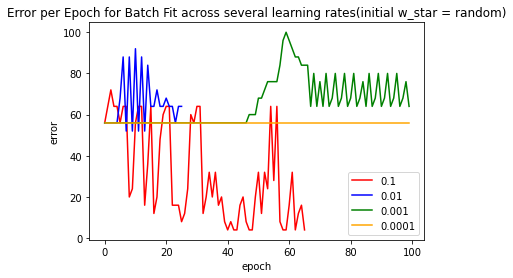

Random initial weight vector: [ 0.9841840637499941 ,  7.560342780463963 ,  6.8271661809788045 ]
Epochs til convergence with learning rate of 0.1 =  5
Epochs til convergence with learning rate of 0.01 =  26
Epochs til convergence with learning rate of 0.001 =  100
Epochs til convergence with learning rate of 0.0001 =  100


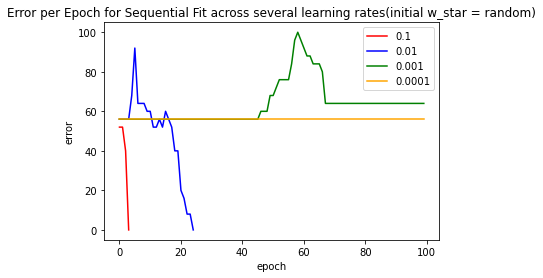

In [14]:
#
#INITIAL WEIGHT VECTOR IS [random[.1,10], random[.1,10], random[.1,10]]
#

#importing random library
import random

#run following code for 3 different random weight vectors

for i in range(3):
   #generating random weight values between .1-10
    random_w0 = random.uniform(.1,10)
    random_w1 = random.uniform(.1,10)
    random_w2 = random.uniform(.1,10)

    #Training using batch fitting
    print("Random initial weight vector: [", random_w0, ", ", random_w1, ", ", random_w2, "]")

    batch_lr3_1 = Perceptron(X1_train, y1_train, learning_rate = .1, max_epochs=100)
    batch_lr3_1.set_w_star(random_w0, random_w1, random_w2)
    batch_lr3_1_w, batch_lr3_1_all_errors, batch_lr3_1_epochs_iterated = batch_lr3_1.batch_fit()
    print("Epochs til convergence with learning rate of 0.1 = ", batch_lr3_1_epochs_iterated)

    batch_lr3_01 = Perceptron(X1_train, y1_train, learning_rate = .01, max_epochs=100)
    batch_lr3_01.set_w_star(random_w0, random_w1, random_w2)
    batch_lr3_01_w, batch_lr3_01_all_errors, batch_lr3_01_epochs_iterated = batch_lr3_01.batch_fit()
    print("Epochs til convergence with learning rate of 0.01 = ", batch_lr3_01_epochs_iterated)

    batch_lr3_001 = Perceptron(X1_train, y1_train, learning_rate = .001, max_epochs=100)
    batch_lr3_001.set_w_star(random_w0, random_w1, random_w2)
    batch_lr3_001_w, batch_lr3_001_all_errors, batch_lr3_001_epochs_iterated = batch_lr3_001.batch_fit()
    print("Epochs til convergence with learning rate of 0.001 = ", batch_lr3_001_epochs_iterated)

    batch_lr3_0001 = Perceptron(X1_train, y1_train, learning_rate = .0001, max_epochs=100)
    batch_lr3_0001.set_w_star(random_w0, random_w1, random_w2)
    batch_lr3_0001_w, batch_lr3_0001_all_errors, batch_lr3_0001_epochs_iterated = batch_lr3_0001.batch_fit()
    print("Epochs til convergence with learning rate of 0.0001 = ", batch_lr3_0001_epochs_iterated)

    #plotting errors for each learning rate
    plt.plot(batch_lr3_1_all_errors, c = "red", label = "0.1")
    plt.plot(batch_lr3_01_all_errors, c = "blue", label = "0.01")
    plt.plot(batch_lr3_001_all_errors, c = "green", label = "0.001")
    plt.plot(batch_lr3_0001_all_errors, c = "orange", label = "0.0001")
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Error per Epoch for Batch Fit across several learning rates(initial w_star = random)')
    plt.show()

    #Training using sequential fitting
    print("Random initial weight vector: [", random_w0, ", ", random_w1, ", ", random_w2, "]")

    sequential_lr3_1 = Perceptron(X1_train, y1_train, learning_rate = .1, max_epochs=100)
    sequential_lr3_1.set_w_star(random_w0, random_w1, random_w2)
    sequential_lr3_1_w, sequential_lr3_1_all_errors, sequential_lr3_1_epochs_iterated = sequential_lr3_1.sequential_fit()
    print("Epochs til convergence with learning rate of 0.1 = ", sequential_lr3_1_epochs_iterated)

    sequential_lr3_01 = Perceptron(X1_train, y1_train, learning_rate = .01, max_epochs=100)
    sequential_lr3_01.set_w_star(random_w0, random_w1, random_w2)
    sequential_lr3_01_w, sequential_lr3_01_all_errors, sequential_lr3_01_epochs_iterated = sequential_lr3_01.sequential_fit()
    print("Epochs til convergence with learning rate of 0.01 = ", sequential_lr3_01_epochs_iterated)

    sequential_lr3_001 = Perceptron(X1_train, y1_train, learning_rate = .001, max_epochs=100)
    sequential_lr3_001.set_w_star(random_w0, random_w1, random_w2)
    sequential_lr3_001_w, sequential_lr3_001_all_errors, sequential_lr3_001_epochs_iterated = sequential_lr3_001.sequential_fit()
    print("Epochs til convergence with learning rate of 0.001 = ", sequential_lr3_001_epochs_iterated)

    sequential_lr3_0001 = Perceptron(X1_train, y1_train, learning_rate = .0001, max_epochs=100)
    sequential_lr3_0001.set_w_star(random_w0, random_w1, random_w2)
    sequential_lr3_0001_w, sequential_lr3_0001_all_errors, sequential_lr3_0001_epochs_iterated = sequential_lr3_0001.sequential_fit()
    print("Epochs til convergence with learning rate of 0.0001 = ", sequential_lr3_0001_epochs_iterated)

    #plotting errors for each learning rate
    plt.plot(sequential_lr3_1_all_errors, c = "red", label = "0.1")
    plt.plot(sequential_lr3_01_all_errors, c = "blue", label = "0.01")
    plt.plot(sequential_lr3_001_all_errors, c = "green", label = "0.001")
    plt.plot(sequential_lr3_0001_all_errors, c = "orange", label = "0.0001")
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.legend()
    plt.title('Error per Epoch for Sequential Fit across several learning rates(initial w_star = random)')
    plt.show()

In [15]:
#Proving that the optimal learning rates for sequential and batch training are different

optimal_batch_epochs = 101  #optimal number of batch epochs to converge
optimal_batch_lr = 0        #optimal batch learning rate
 
lr_list= np.linspace(0.0001,1,1000)   #holds 1000 possible learning rates from 0.0001-1

for i in range(len(lr_list)):
    batch_lrtest = Perceptron(X1_train, y1_train, learning_rate = lr[i], max_epochs=100)
    batch_lrtest.set_w_star(0.1, 0.1, 0.1)
    batch_lrtest_w, batch_lrtest_all_errors, batch_lrtest_epochs_iterated = batch_lrtest.batch_fit()
    if(batch_lrtest_epochs_iterated < optimal_batch_epochs):
        optimal_batch_epochs = batch_lrtest_epochs_iterated
        optimal_batch_lr = lr[i]
print("optimal batch lr: ", optimal_batch_lr)
print("epochs til convergence: ", optimal_batch_epochs)

optimal_sequential_epochs = 101          #optimal number of batch epochs to converge
optimal_sequential_lr = 0                #optimal batch learning rate



for i in range(len(lr)):
    seq_lrtest = Perceptron(X1_train, y1_train, learning_rate = lr[i], max_epochs=100)
    seq_lrtest.set_w_star(0.1, 0.1, 0.1)
    seq_lrtest_w, seq_lrtest_all_errors, seq_lrtest_epochs_iterated = seq_lrtest.sequential_fit()
    if(seq_lrtest_epochs_iterated < optimal_sequential_epochs):
        optimal_sequential_epochs = seq_lrtest_epochs_iterated
        optimal_sequential_lr = lr[i]
print("optimal sequential lr: ", optimal_sequential_lr)
print("epochs til convergence: ", optimal_sequential_epochs)

NameError: name 'lr' is not defined

__I tested out several learning rates when training my model to see which one converged in the least number of epochs. As you can see on the graphs above, the optimal learning rate will vary based on the initial weight vector:__  

__If the initial weight vector is [0,0,0], the learning rate does not affect the convergence rate whatsoever. This is because the learning rate is only adjusting the magnitude of the weight vector due to the weight vector being only influenced by the data.__  

__If the initial weight vector is [0.1,0.1,0.1], the optimal learning rate is 0.001(out of those that I tested), for both sequential and batch fit. The learning rate of 0.001 is close to being optimal for batch fit, but is very bad for sequential fit in this case. In addition, the learning rate of 0.1 is very poor for batch fit, but is almost optimal for sequential. This hinted at what I later proved(the function right above this), that the optimal learning rate for batch and sequential training can differ. We can see that the optimal batch learning rate for this initial weight vector is ~0.0011, converging after 39 epochs. However, the optimal sequential learning rate for this initial weight vector is ~0.0051, converging after only 2 epochs.__  

__If the initial weight vector is random, the optimal learning rate will vary on a case-by-case basis. I showed several examples of this on the graphs above.__  

__1b1)__ _Use Python to generate a 2D not linearly separable data set with 50 data points. The 
data set should have approximately half positive and half negative instances. Create 
a scatter plot to visualize the data set._

In [ ]:
num_features2 = 2
num_datapoints2 = 50
X2, y2 = datasets.make_blobs(n_samples=num_datapoints2, centers=2, n_features=num_features2, center_box=(0, 10), cluster_std=2, random_state=1247)
plt.plot(X2[:, 0][y2 == 0], X2[:, 1][y2 == 0], 'g^')
plt.plot(X2[:, 0][y2 == 1], X2[:, 1][y2 == 1], 'bs')
plt.title("Not linearly separable data set")
plt.show()

y2 = y2*2-1
y2 = y2.reshape(num_datapoints2, 1)

#splitting into 60-40 training/testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.4,random_state=23)

__1b2)__ _Modify the training algorithm you developed in a.(2) to have a training algorithm 
that works on a nonseparable data set. Use the synthetic data set in b.(1) to test 
your algorithm. Show the error function curve. Plot the decision boundary on the 
scatter plot of the data set._

__Labeled function as "Non separable batch fit" in my Perceptron class above  
Added "predict nonseparable classes" and "Calculate nonseparable error" to go along with this new function__ 

In [ ]:
#training using batch fitting
non_separable_batch_perceptron = Perceptron(X2_train, y2_train, learning_rate = .1, max_epochs=100)
non_separable_batch_w_vectors, non_separable_batch_w_importances, non_separable_batch_all_errors, non_separable_batch_epochs_iterated = non_separable_batch_perceptron.non_separable_batch_fit(verbose = False, plot = False)

In [ ]:
non_separable_batch_perceptron.plot_final()

In [ ]:
#plotting error
plt.plot(non_separable_batch_all_errors)
plt.ylabel('error')
plt.xlabel('epoch')
plt.title('Error per Epoch for Non-Separable Batch Fit')
plt.show()

In [ ]:
#calculating error for test dataset with batch fit
batch_y2_pred = []
concatenated_X2_test = np.c_[np.ones(len(y2_test)), X2_test]  #adding 1's to front of X_test for bias
for i in range(len(concatenated_X2_test)):
    batch_y2_pred.append(non_separable_batch_perceptron.predict_nonseparable_class(concatenated_X2_test[i], non_separable_batch_w_importances, non_separable_batch_w_vectors))
batch_acc2 = accuracy_score(y2_test, batch_y2_pred)
print("Accuracy score for Average Batch Perceptron: ", batch_acc2)